# Trabalho #4 - Classificação multiclasse

Nesse trabalho você vai treinar uma rede para realizar uma tarefa de classificação multiclasse.

A tarefa é classificar imagens de dígitos numéricos chineses.

## Coloque seu nome aqui:

Aluno: Bruno Pinto de Oliveira

RA: 21.84712-4

### Importação das principais bibliotecas

Em primeiro lugar é necessário importar alguns pacotes do Python que serão usados nesse trabalho.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os

## 1 - Visão geral do problema

O objetivo desse problema é determinar o dígito da lingua chinesa que é mostrado em uma imagem usando uma RNA. Assim, esse problema consiste em dada uma imagem, a RNA avalia a probabilidade de existirem determinados dígitos na imagem e determina qual o mais provável entre 15 possíveis.

O banco de dados usado nesse exemplo é o Chinese-MNIST, que consiste de imagens de dígitos chineses. Esse banco de dados pode ser obtido no Kaggle em https://www.kaggle.com/gpreda/chinese-mnist.

## 2 - Dados de treinamento

Características dos dados:

- O banco de dados Chinese MNIST possui 15.000 exemplos;
- Cada exemplo consiste de uma imagem em tons de cinza, de dimensão 64x64 pixels;
- Cada imagem é associada a um rótulo de 15 classes;
- O valor da intensidade luminosa de cada pixel da imagem é um número inteiro entre 0 e 255.

Primeiramente você deve acessar o link do Kaggle onde se encontra os dados e fazer download dos mesmos e descompactar o arquivo. 


### 2.1 Carregar dados

Após descompactar o arquivo com os dados execute as células abaixo para carregar e inspecionar os dados.

Note que os dados devem estar em uma pasta de nome `Chinese_MNIST` e as imagens estão dentro da pasta `Chinese_MNIST/data`.

O arquivo `chinese_mnist.csv` contém os nomes dos arquivos das imagens codificados e as classes de cada imagem.

In [4]:
# Carrega arquivo de informações sobre dados
data_df = pd.read_csv('Chinese_MNIST/chinese_mnist.csv')
data_df.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


### 2.2 Inspecionar dados

Vamos verificar o número de dados de cada classe de dígito, se existem dados ausentes e quantos arquivos de imagens existem.

In [5]:
data_df.groupby(["value","character"]).size()

value      character
0          零            1000
1          一            1000
2          二            1000
3          三            1000
4          四            1000
5          五            1000
6          六            1000
7          七            1000
8          八            1000
9          九            1000
10         十            1000
100        百            1000
1000       千            1000
10000      万            1000
100000000  亿            1000
dtype: int64

In [6]:
# Verifica se existem dados ausentes
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
suite_id,0,0.0
sample_id,0,0.0
code,0,0.0
value,0,0.0
character,0,0.0


In [7]:
# Verifica número de arquivos de imagens existentes
image_files = list(os.listdir("Chinese_MNIST/data"))
print("Numero de imagens: {}".format(len(image_files)))

Numero de imagens: 15000


### 2.3 Anexar propriedades das imagens ao dataframe

Como as imagens tem uma convenção de nome de `input_ [siote_id] _ [sample_id] _ [código] .jpg`, devemos criar mais uma coluna no dataframe com o nome do arquivo das imagens para podermos associar cada imagem à sua classe correspondente.

In [8]:
import skimage.io

def image_files(x):
    file_name = f"input_{x[0]}_{x[1]}_{x[2]}.jpg"
    return file_name
data_df["file"] = data_df.apply(image_files, axis=1)

def image_sizes(file_name):
    image = skimage.io.imread("Chinese_MNIST/data/" + file_name)
    return list(image.shape)

data_df = pd.concat([data_df],axis=1, sort=False)

data_df.head()

,suite_id,sample_id,code,value,character,file
0,1,1,10,9,九,input_1_1_10.jpg
1,1,10,10,9,九,input_1_10_10.jpg
2,1,2,10,9,九,input_1_2_10.jpg
3,1,3,10,9,九,input_1_3_10.jpg
4,1,4,10,9,九,input_1_4_10.jpg


## 3. Processamento dos dados

Primeiramente precisamos dividir os dados nos conjuntos de treinamento e teste. Vamos usar 80% para treinamento e 20% para teste/validação.

In [9]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42, stratify=data_df["code"].values)

print("Train set: {}".format(train_df.shape))
print("Test set: {}".format(test_df.shape))

Train set: (12000, 6)
Test set: (3000, 6)


As imagens precisam ser carregadas, redimensionadas e normalizadas. Para isso vamos usar uma função que carrega as imagens, redimensiona-as para (64, 64) e normaliza os pixels para terem valores reais entre 0 e 1.

Precisamos também de uma função para criar a classe do dígito correspondente a cada imagem.

In [10]:
import skimage.transform

def read_image(file_name):
    #print(file_name)
    image = skimage.io.imread("Chinese_MNIST/data/" + file_name)
    image = skimage.transform.resize(image, (64, 64), mode='reflect')
    return image

def categories_encoder(dataset, var='character'):
    X = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

X_train, y_train = categories_encoder(train_df)
X_test, y_test = categories_encoder(test_df)

print('Dimensão do tensor das imagens de treinamento:', X_train.shape)
print('Dimensão do tensor das imagens de teste:', X_test.shape)
print('Dimensão do tensor de classes de treinamento:', y_train.shape)
print('Dimensão do tensor de classes de teste:', y_test.shape)

Dimensão do tensor das imagens de treinamento: (12000, 64, 64)
Dimensão do tensor das imagens de teste: (3000, 64, 64)
Dimensão do tensor de classes de treinamento: (12000, 15)
Dimensão do tensor de classes de teste: (3000, 15)


Como vamos processar as imagens com uma rede de camadas densas, devemos transformá-las em vetores.

In [11]:
# Redimensionamento das images 
X_train_flat = np.reshape(X_train, (12000, 64*64))
X_test_flat = np.reshape(X_test, (3000, 64*64))

# Transformação das saídas em tensor numpy
y_train = np.array(y_train)
y_test = np.array(y_test)

print('Dimensão do tensor das imagens de treinamento:', X_train_flat.shape)
print('Dimensão do tensor das imagens de teste:', X_test_flat.shape)
print('Dimensão do tensor de classes de treinamento:', y_train.shape)
print('Dimensão do tensor de classes de teste:', y_test.shape)
print('Valores mímnimo e máximo dos pixels das imagens:', np.min(X_train_flat), np.max(X_train_flat))

Dimensão do tensor das imagens de treinamento: (12000, 4096)
Dimensão do tensor das imagens de teste: (3000, 4096)
Dimensão do tensor de classes de treinamento: (12000, 15)
Dimensão do tensor de classes de teste: (3000, 15)
Valores mímnimo e máximo dos pixels das imagens: 0.0 1.0


y = 4 (y_hot=[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0])


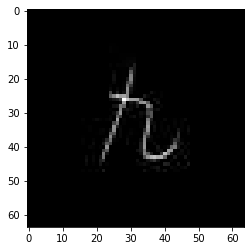

In [12]:
# Exemplo de uma imagem
index = 11
plt.imshow(X_train[index], cmap='gray')
print ("y = " + str(np.argmax(y_train[index])) + " (y_hot=" + str(y_train[index]) + ")")

## 3. Para você fazer

Você deve desenvolver uma rede neural usando a plataforma TensorFlow-Keras, para classificar os dígitos escritos em chinês.

Além de mostrar a configuração da rede utilizada, os parâmetros escolhidos para a compilação e treinamento, apresente pelo menos os seguintes resultados:

1. Resultado do processo de treinamento (gráficos);

2. Valores da função de custo e da métrica para os dados de treinamento e teste (use o método evaluate);

3. Gráfico com as classes previstas junto com as classes reais dos dados de teste. Use círculos de cores diferentes para diferenciar as classe previstas das reais.

4. Matriz de confusão dos resulatdos para facilitar a análise de desempenho da sua rede.

Para entregar o seu trabalho, transforme o seu notebook em pdf e faça o upload do mesmo nesse espaço.  

## 3.1 Configuração da RNA

In [21]:
# Importa bibliotecas do TensorFlow
from tensorflow.keras import models
from tensorflow.keras import layers


# Configuração da RNA
rna = models.Sequential()

# Determinação dos números de neurônios e do número de camadas. 'input_shate' recebe o valor de 64*64px = 4096.
rna.add(layers.Dense(256, activation='relu', input_shape=(X_train_flat.shape[1],)))
rna.add(layers.Dense(64,activation='relu'))
rna.add(layers.Dense(15, activation='softmax'))


# Mostra resuma da rede
rna.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               1048832   
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 15)                975       
Total params: 1,066,255
Trainable params: 1,066,255
Non-trainable params: 0
_________________________________________________________________


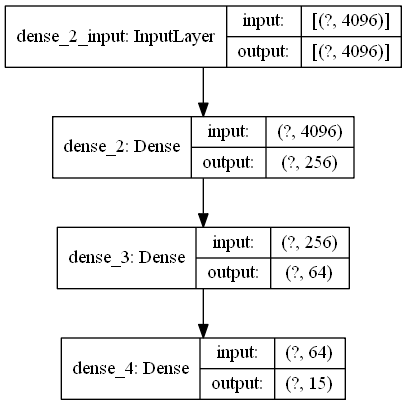

In [22]:
from tensorflow.keras.utils import plot_model
import pydot

# Ilustra a representação esquemática do RNA
plot_model(rna, to_file='rna.png', show_shapes=True)

## 3.2 Compilação da RNA

In [23]:
# Importa classe dos otimizadores
from tensorflow.keras import optimizers

# Define otimizador RMSprop com taxa de aprendizado igual a 0.01
rms = optimizers.RMSprop(lr=0.001)

# Compilaçõ da RNA
rna.compile(optimizer=rms, loss='categorical_crossentropy', metrics=['accuracy'])

## 3.3 Treinamento da RNA

In [24]:
history = rna.fit(X_train_flat, y_train, epochs=25, batch_size=500, validation_data=(X_test_flat, y_test))

Epoch 1/25
24/24 [==============================] - 4s 173ms/step - loss: 2.2848 - accuracy: 0.3043 - val_loss: 2.0007 - val_accuracy: 0.4270
Epoch 2/25
24/24 [==============================] - 1s 51ms/step - loss: 1.7763 - accuracy: 0.4976 - val_loss: 1.7204 - val_accuracy: 0.5113
Epoch 3/25
24/24 [==============================] - 1s 54ms/step - loss: 1.4889 - accuracy: 0.5825 - val_loss: 1.5171 - val_accuracy: 0.5610
Epoch 4/25
24/24 [==============================] - 1s 53ms/step - loss: 1.2661 - accuracy: 0.6422 - val_loss: 1.3850 - val_accuracy: 0.5940
Epoch 5/25
24/24 [==============================] - 1s 51ms/step - loss: 1.0863 - accuracy: 0.6959 - val_loss: 1.2135 - val_accuracy: 0.6453
Epoch 6/25
24/24 [==============================] - 1s 55ms/step - loss: 0.9319 - accuracy: 0.7424 - val_loss: 1.1350 - val_accuracy: 0.6643
Epoch 7/25
24/24 [==============================] - 2s 73ms/step - loss: 0.8054 - accuracy: 0.7795 - val_loss: 1.0197 - val_accuracy: 0.6990
Epoch 8/25
2

## 3.4 Visualização do resultado do treinamento

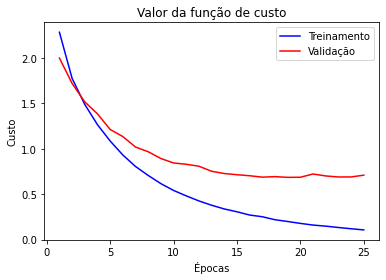

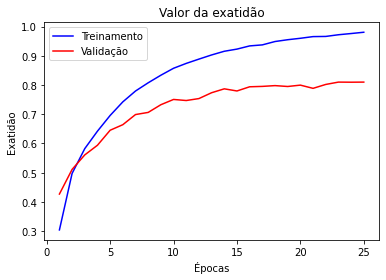

In [25]:
# Salva custo e exatidão em vetores
history_dict = history.history
custo = history_dict['loss']
exatidao = history_dict['accuracy']
custo_val = history_dict['val_loss']
exatidao_val = history_dict['val_accuracy']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico do custo em função das épocas
custo = history_dict['loss']
plt.plot(epocas, custo, 'b', label='Treinamento')
plt.plot(epocas, custo_val, 'r', label='Validação')
plt.title('Valor da função de custo')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico da exatidão em função das épocas
plt.plot(epocas, exatidao, 'b', label='Treinamento')
plt.plot(epocas, exatidao_val, 'r', label='Validação')
plt.title('Valor da exatidão')
plt.xlabel('Épocas')
plt.ylabel('Exatidão')
plt.legend()
plt.show()

## 3.5 Avaliação do desempenho da rede

In [26]:
# Calculo do custo e exatidão para os dados de treinamento, validação e teste
custo_e_metricas_train = rna.evaluate(X_train_flat, y_train)
custo_e_metricas_test = rna.evaluate(X_test_flat, y_test)

94/94 [==============================] - 0s 4ms/step - loss: 0.7094 - accuracy: 0.8100


## 3.6 Teste de previsão da RNA

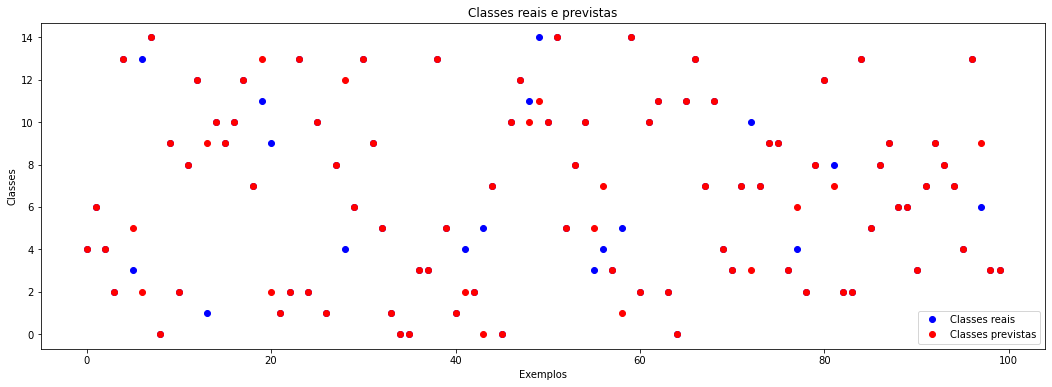

In [27]:
# Calcula das classes previstas
y_prev = rna.predict(X_test_flat)


# Identifica classe prevista
classe_prev = np.argmax(y_prev, axis=1)
classe_real = np.argmax(y_test, axis=1)


# Gráfico das classes reais e previstas para os primeiros 200 exemplos de teste
plt.figure(figsize=(18,6))
plt.plot(classe_real[:100], 'bo', label='Classes reais')
plt.plot(classe_prev[:100], 'ro', label="Classes previstas")
plt.title('Classes reais e previstas')
plt.xlabel('Exemplos')
plt.ylabel('Classes')
plt.legend()
plt.show()

Classe real: 1 - [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] ; Classe prevista: 1


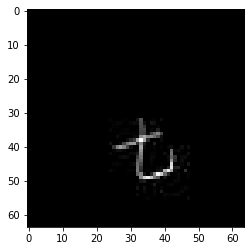

In [28]:
# Exemplo de classificação de uma imagem.
index = 40
plt.imshow(X_test[index,:], cmap='gray')
print ("Classe real:", str(np.argmax(y_test[index])), '-',y_test[index], ';',
#print ("Classe real:", y_test[index], '-', ';',
       
      
"Classe prevista:", classe_prev[index],)

## 3.7 Matriz de confusão

### 3.7.1 Modelo 1

Matriz de confusão:
 [[191   0   0   0   0   6   0   0   0   3   0   0   0   0   0]
 [  0 145   2   0  17   3   7   5   1   7   4   2   4   3   0]
 [  0   1 147   0   3   0   2   1   0   7   0   2   6  22   9]
 [  0   2   0 170   0  18   6   0   0   1   0   2   0   1   0]
 [  0   6  15   0 126   0   5  28   3   3   1   3   2   6   2]
 [  5   2   0  21   0 168   0   1   0   2   1   0   0   0   0]
 [  0   3   3   4   3   0 168   1   1   4   2   1   0  10   0]
 [  0   0   1   1  14   0   3 169   0   2   0   1   8   1   0]
 [  0   1   7   0   1   1   0   4 181   3   0   0   2   0   0]
 [  0   3  10   2  12   0   0   3   2 158   3   1   3   2   1]
 [  0   0   6   2   1   1   0   0   0   2 166  20   1   0   1]
 [  0   3   1   1   3   2   4   1   0   5  41 132   1   5   1]
 [  0   0   2   0   2   0   1  10   0   1   2   0 174   7   1]
 [  0   3  23   1   5   0   3   2   2   2   0   1   1 152   5]
 [  0   0   5   0   1   0   0   0   0   0   0   2   1   8 183]]


<ipython-input-33-e94378991a03>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-33-e94378991a03>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


<Figure size 432x432 with 0 Axes>

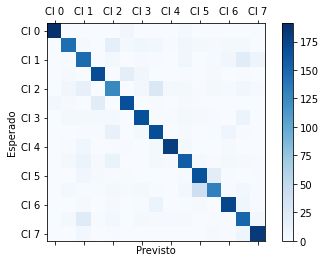

In [33]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=classe_real, y_pred=np.round(classe_prev))
print('Matriz de confusão:\n', conf_mat)
labels = ['Cl 0', 'Cl 1', 'Cl 2', 'Cl 3', 'Cl 4', 'Cl 5', 'Cl 6', 'Cl 7', 'Cl 8']
plt.figure(figsize=(6,6))
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Previsto')
plt.ylabel('Esperado')
plt.show()

### 3.7.2 Modelo 2

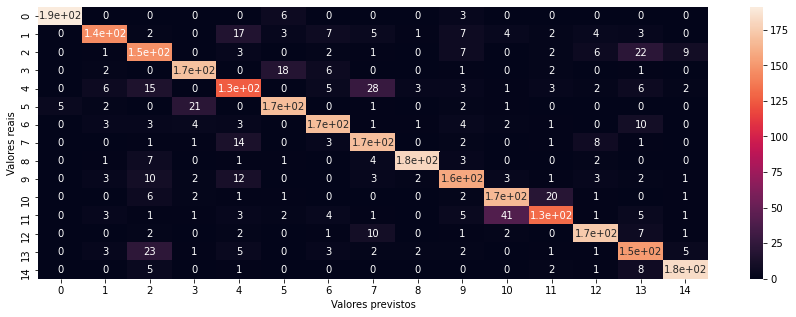

In [41]:
#Matriz de confusão
import seaborn as sn

plt.figure(figsize= (15,5))
cm = confusion_matrix(np.argmax(y_test, axis=1), classe_prev)
sn.heatmap(cm, annot= True)
plt.xlabel('Valores previstos')
plt.ylabel('Valores reais')
plt.show()